# Gemma2-27B Attention Analysis

This notebook analyzes how instruction tuning modifies attention patterns for PC and semantic vectors.

**Key Analyses:**
1. **QK Affinity**: Raw attention logits (before softmax) reveal semantic affinities
2. **VO Decomposition**: What semantic content flows through when attending to a vector
3. **Base vs Instruct Comparison**: How instruction tuning changes routing

**Approach:**
- Compute QK affinity matrices for PC and semantic vectors
- Compute VO decomposition (value-output transformation)
- Analyze z-scores relative to random baseline
- Identify layers and patterns where instruction tuning has strongest effect

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoConfig
from collections import OrderedDict

from chatspace.analysis import (
    load_pca_data,
    extract_pc_components,
    load_individual_role_vectors,
    load_individual_trait_vectors,
    normalize_vector,
    compute_qk_affinity_matrix,
    compute_vo_decomposition,
    compute_z_score_matrices,
    get_top_interactions,
    analyze_pc_pattern
)

%matplotlib inline
sns.set_style('whitegrid')

## 1. Load Models and Prepare Vectors

In [2]:
# Load models
base_model_id = "google/gemma-2-27b"
instruct_model_id = "google/gemma-2-27b-it"

print("Loading models...")
config = AutoConfig.from_pretrained(base_model_id)
base_model = AutoModelForCausalLM.from_pretrained(base_model_id, torch_dtype=torch.bfloat16, device_map="cpu")
instruct_model = AutoModelForCausalLM.from_pretrained(instruct_model_id, torch_dtype=torch.bfloat16, device_map="cpu")
print("✓ Models loaded")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading models...


Loading checkpoint shards:   0%|          | 0/24 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]

✓ Models loaded


In [3]:
# Load PCA data and extract all PCs we'll analyze
persona_data_root = Path("/workspace/persona-data")
roles_pca_dir = persona_data_root / "gemma-2-27b" / "roles_240" / "pca"
traits_pca_dir = persona_data_root / "gemma-2-27b" / "traits_240" / "pca"

pca_data, _ = load_pca_data(roles_pca_dir)
pca_layer = pca_data['layer']

# Extract ALL PCs we'll use (load 10 for flexibility)
n_pcs_total = 10
pcs_all, variance_all = extract_pc_components(pca_data, n_components=n_pcs_total)

print(f"✓ Loaded PCA data from layer {pca_layer}")
print(f"  Extracted {n_pcs_total} PCs")
print(f"  Variance explained by first 5 PCs: {variance_all[:5]}")

# Build test vectors: ALL PCs + random baseline
test_vecs_full = OrderedDict()

# Add all PCs (positive and negative)
for pc_idx in range(n_pcs_total):
    pc_name = f"PC{pc_idx+1}"
    test_vecs_full[pc_name] = normalize_vector(pcs_all[pc_idx])
    test_vecs_full[f"-{pc_name}"] = normalize_vector(-pcs_all[pc_idx].float())

# Add random baseline vectors
torch.manual_seed(42)
n_random = 20
for i in range(n_random):
    rand_vec = torch.randn(config.hidden_size, dtype=torch.float32)
    test_vecs_full[f"Random{i+1}"] = normalize_vector(rand_vec)

vec_names_full = list(test_vecs_full.keys())
vecs_tensor_full = torch.stack([test_vecs_full[name] for name in vec_names_full])

print(f"\n✓ Prepared {len(vec_names_full)} vectors:")
print(f"  {n_pcs_total*2} PCs (positive + negative)")
print(f"  {n_random} random baseline vectors")

✓ Loaded PCA data from layer 22
  Extracted 10 PCs
  Variance explained by first 5 PCs: [0.21216452 0.08200892 0.06822039 0.05221459 0.04578365]

✓ Prepared 40 vectors:
  20 PCs (positive + negative)
  20 random baseline vectors


/root/chatspace/.venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/root/chatspace/.venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
# ============================================================================
# CONFIGURATION: Set analysis parameters here
# ============================================================================

# Which layers to compute attention patterns for
# ALL layers: 0-45 (46 total)
analysis_layers = list(range(config.num_hidden_layers))

# Which layers to use for averaging in PC comparison plots
# Middle layers where instruction tuning is most active
comparison_layers = list(range(17, 28))  # Layers 17-27

# Which PCs to visualize in layer-wise plots
plot_pcs = ["PC1", "PC2", "PC3"]
# plot_pcs = ["PC1"]  # Uncomment to focus on PC1 only

# How many PCs to include in PC number comparison
n_pcs_compare = 10

print(f"📋 Analysis Configuration:")
print(f"  Computing attention for {len(analysis_layers)} layers (all)")
print(f"  Averaging over layers {comparison_layers[0]}-{comparison_layers[-1]} for PC comparison")
print(f"  Visualizing {len(plot_pcs)} PCs in layer-wise plots: {plot_pcs}")
print(f"  Comparing {n_pcs_compare} PCs in PC number analysis")

📋 Analysis Configuration:
  Computing attention for 46 layers (all)
  Averaging over layers 17-27 for PC comparison
  Visualizing 3 PCs in layer-wise plots: ['PC1', 'PC2', 'PC3']
  Comparing 10 PCs in PC number analysis


## 2. Compute QK and VO Patterns for All Layers

Compute attention patterns once for all PCs and all layers.

In [5]:
# Compute QK affinity and VO decomposition for all layers
print(f"Computing QK and VO for {len(analysis_layers)} layers...")

n_vecs_full = len(vec_names_full)
qk_base_full = np.zeros((len(analysis_layers), n_vecs_full, n_vecs_full))
qk_inst_full = np.zeros((len(analysis_layers), n_vecs_full, n_vecs_full))
vo_base_full = np.zeros((len(analysis_layers), n_vecs_full, n_vecs_full))
vo_inst_full = np.zeros((len(analysis_layers), n_vecs_full, n_vecs_full))

with torch.inference_mode():
    for i, layer_idx in enumerate(tqdm(analysis_layers, desc="Computing attention patterns")):
        # QK affinity
        qk_b = compute_qk_affinity_matrix(vecs_tensor_full, layer_idx, base_model)
        qk_i = compute_qk_affinity_matrix(vecs_tensor_full, layer_idx, instruct_model)
        qk_base_full[i] = qk_b.cpu().numpy()
        qk_inst_full[i] = qk_i.cpu().numpy()
        
        # VO decomposition
        vo_b = compute_vo_decomposition(vecs_tensor_full, vecs_tensor_full, layer_idx, base_model)
        vo_i = compute_vo_decomposition(vecs_tensor_full, vecs_tensor_full, layer_idx, instruct_model)
        vo_base_full[i] = vo_b.cpu().numpy()
        vo_inst_full[i] = vo_i.cpu().numpy()

print(f"\n✓ Computed QK and VO for {len(analysis_layers)} layers")
print(f"  Arrays shape: {qk_base_full.shape}")

Computing QK and VO for 46 layers...


Computing attention patterns: 100%|██████████| 46/46 [00:16<00:00,  2.78it/s]


✓ Computed QK and VO for 46 layers
  Arrays shape: (46, 40, 40)


In [6]:
# Compute z-scores using random baseline
random_indices_full = [vec_names_full.index(n) for n in vec_names_full if "Random" in n]

print("Computing random baselines for base and instruct models...")

# Base model random baseline
qk_random_base = []
vo_random_base = []
for rand_idx in random_indices_full:
    qk_random_base.append(qk_base_full[:, rand_idx, rand_idx])
    vo_random_base.append(vo_base_full[:, rand_idx, rand_idx])
qk_random_base = np.array(qk_random_base)
vo_random_base = np.array(vo_random_base)
qk_base_mean = qk_random_base.mean(axis=0)
qk_base_std = qk_random_base.std(axis=0)
vo_base_mean = vo_random_base.mean(axis=0)
vo_base_std = vo_random_base.std(axis=0)

# Instruct model random baseline
qk_random_inst = []
vo_random_inst = []
for rand_idx in random_indices_full:
    qk_random_inst.append(qk_inst_full[:, rand_idx, rand_idx])
    vo_random_inst.append(vo_inst_full[:, rand_idx, rand_idx])
qk_random_inst = np.array(qk_random_inst)
vo_random_inst = np.array(vo_random_inst)
qk_inst_mean = qk_random_inst.mean(axis=0)
qk_inst_std = qk_random_inst.std(axis=0)
vo_inst_mean = vo_random_inst.mean(axis=0)
vo_inst_std = vo_random_inst.std(axis=0)

# Extract PC patterns and convert to z-scores
qk_zscores_base = {}
qk_zscores_inst = {}
vo_zscores_base = {}
vo_zscores_inst = {}

for pc_idx in range(n_pcs_total):
    pc_name = f"PC{pc_idx+1}"
    pc_neg_name = f"-{pc_name}"
    
    pc_pos_idx = vec_names_full.index(pc_name)
    pc_neg_idx = vec_names_full.index(pc_neg_name)
    
    # Positive PC patterns
    qk_zscores_base[pc_name] = {
        "self": (qk_base_full[:, pc_pos_idx, pc_pos_idx] - qk_base_mean) / (qk_base_std + 1e-8),
        "opposite": (qk_base_full[:, pc_pos_idx, pc_neg_idx] - qk_base_mean) / (qk_base_std + 1e-8)
    }
    qk_zscores_inst[pc_name] = {
        "self": (qk_inst_full[:, pc_pos_idx, pc_pos_idx] - qk_inst_mean) / (qk_inst_std + 1e-8),
        "opposite": (qk_inst_full[:, pc_pos_idx, pc_neg_idx] - qk_inst_mean) / (qk_inst_std + 1e-8)
    }
    vo_zscores_base[pc_name] = {
        "self": (vo_base_full[:, pc_pos_idx, pc_pos_idx] - vo_base_mean) / (vo_base_std + 1e-8),
        "opposite": (vo_base_full[:, pc_pos_idx, pc_neg_idx] - vo_base_mean) / (vo_base_std + 1e-8)
    }
    vo_zscores_inst[pc_name] = {
        "self": (vo_inst_full[:, pc_pos_idx, pc_pos_idx] - vo_inst_mean) / (vo_inst_std + 1e-8),
        "opposite": (vo_inst_full[:, pc_pos_idx, pc_neg_idx] - vo_inst_mean) / (vo_inst_std + 1e-8)
    }

print(f"✓ Computed z-scores for {n_pcs_total} PCs")
print(f"  Each model normalized by {len(random_indices_full)} random vectors")

Computing random baselines for base and instruct models...
✓ Computed z-scores for 10 PCs
  Each model normalized by 20 random vectors


## 3. Layer-wise PC Attention Patterns

Visualize how PCs attend to themselves and their opposites across layers.

In [7]:
# Compute deltas (Instruct - Base) for configured PCs
qk_delta_zscores = {}
vo_delta_zscores = {}

for pc in plot_pcs:
    qk_delta_zscores[pc] = {
        "self": qk_zscores_inst[pc]["self"] - qk_zscores_base[pc]["self"],
        "opposite": qk_zscores_inst[pc]["opposite"] - qk_zscores_base[pc]["opposite"]
    }
    vo_delta_zscores[pc] = {
        "self": vo_zscores_inst[pc]["self"] - vo_zscores_base[pc]["self"],
        "opposite": vo_zscores_inst[pc]["opposite"] - vo_zscores_base[pc]["opposite"]
    }

print(f"✓ Computed deltas for {len(plot_pcs)} PCs: {plot_pcs}")

✓ Computed deltas for 3 PCs: ['PC1', 'PC2', 'PC3']


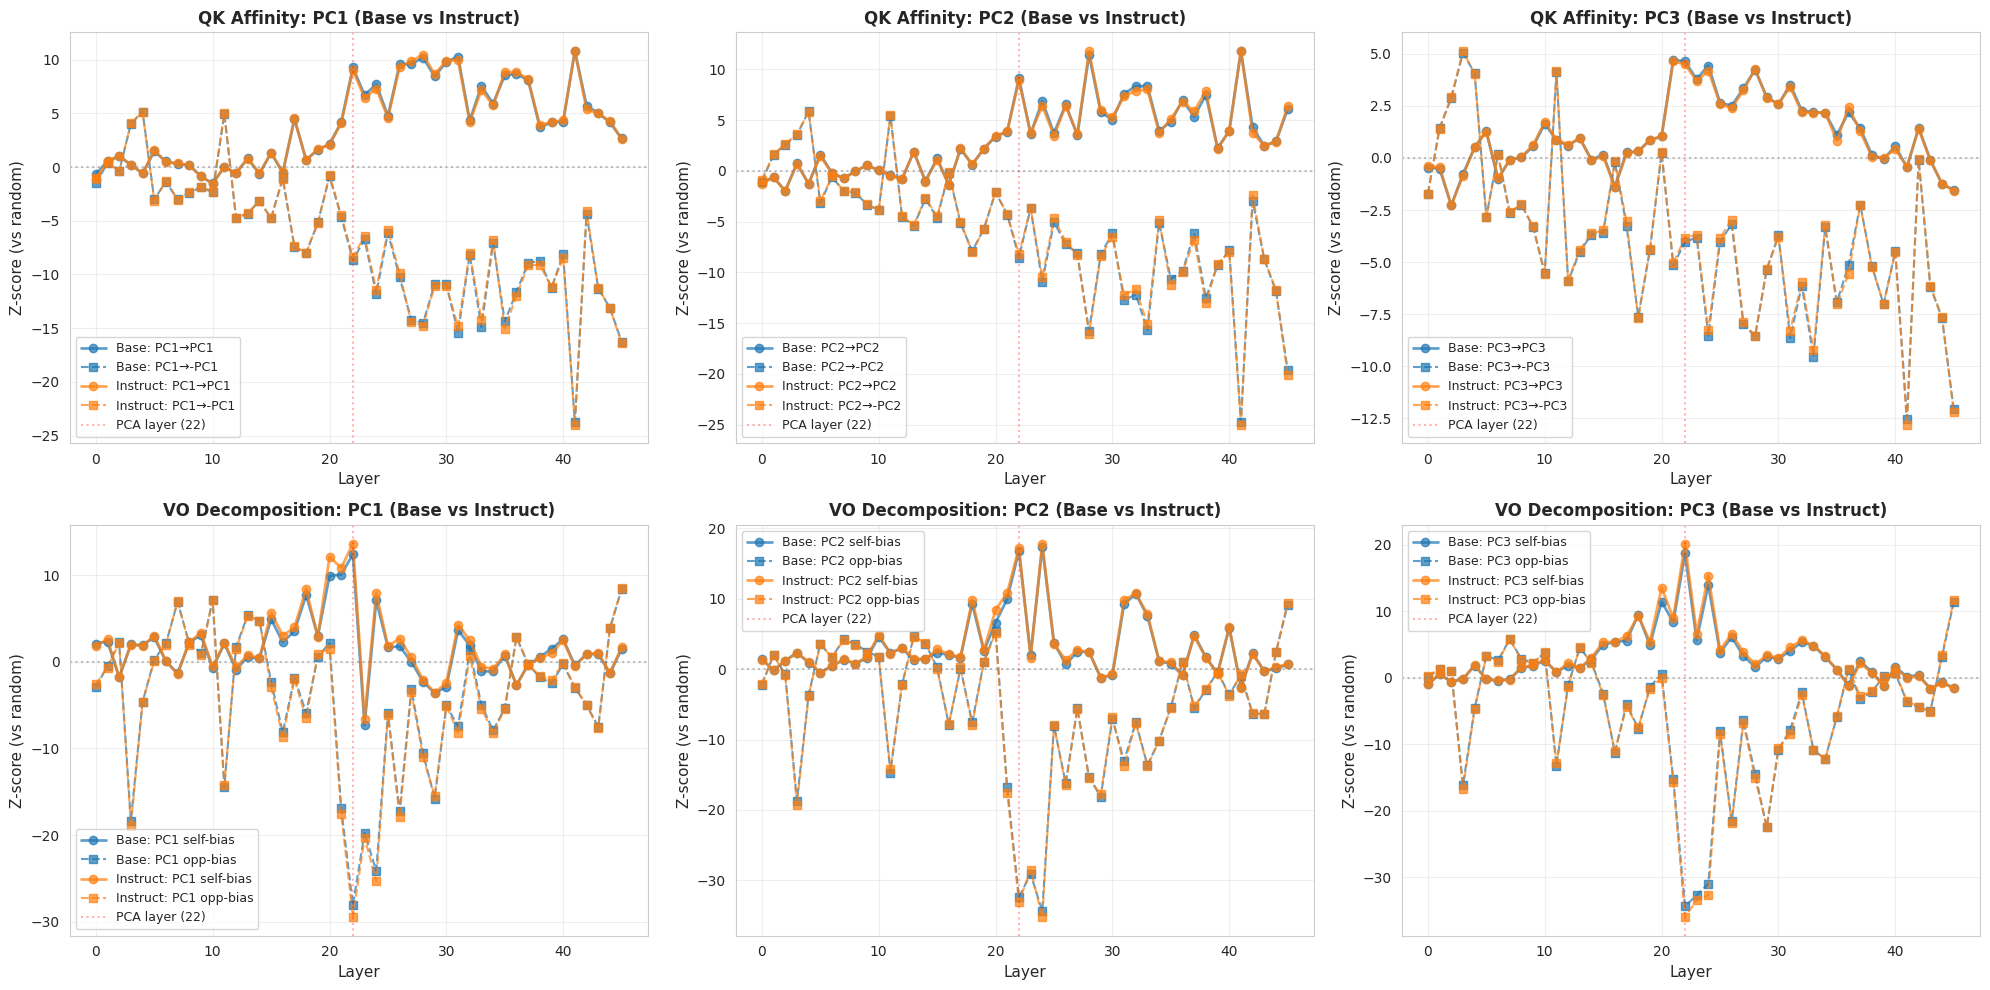

In [8]:
# Visualize base vs instruct attention patterns
fig, axes = plt.subplots(2, len(plot_pcs), figsize=(20, 10))

# QK Affinity plots (top row)
for i, pc in enumerate(plot_pcs):
    if len(plot_pcs) == 1:
        ax = axes[0]
    else:
        ax = axes[0, i]
    
    # Plot base model
    ax.plot(analysis_layers, qk_zscores_base[pc]["self"], "o-", 
            label=f"Base: {pc}→{pc}", linewidth=2, alpha=0.7, color="C0")
    ax.plot(analysis_layers, qk_zscores_base[pc]["opposite"], "s--", 
            label=f"Base: {pc}→-{pc}", linewidth=1.5, alpha=0.7, color="C0")
    
    # Plot instruct model
    ax.plot(analysis_layers, qk_zscores_inst[pc]["self"], "o-", 
            label=f"Instruct: {pc}→{pc}", linewidth=2, alpha=0.7, color="C1")
    ax.plot(analysis_layers, qk_zscores_inst[pc]["opposite"], "s--", 
            label=f"Instruct: {pc}→-{pc}", linewidth=1.5, alpha=0.7, color="C1")
    
    ax.axhline(0, color="gray", linestyle=":", alpha=0.5)
    ax.axvline(pca_layer, color="red", linestyle=":", alpha=0.3, label=f"PCA layer ({pca_layer})")
    ax.set_xlabel("Layer", fontsize=11)
    ax.set_ylabel("Z-score (vs random)", fontsize=11)
    ax.set_title(f"QK Affinity: {pc} (Base vs Instruct)", fontsize=12, fontweight="bold")
    ax.legend(fontsize=9, loc="best")
    ax.grid(True, alpha=0.3)

# VO Decomposition plots (bottom row)
for i, pc in enumerate(plot_pcs):
    if len(plot_pcs) == 1:
        ax = axes[1]
    else:
        ax = axes[1, i]
    
    # Plot base model
    ax.plot(analysis_layers, vo_zscores_base[pc]["self"], "o-", 
            label=f"Base: {pc} self-bias", linewidth=2, alpha=0.7, color="C0")
    ax.plot(analysis_layers, vo_zscores_base[pc]["opposite"], "s--", 
            label=f"Base: {pc} opp-bias", linewidth=1.5, alpha=0.7, color="C0")
    
    # Plot instruct model
    ax.plot(analysis_layers, vo_zscores_inst[pc]["self"], "o-", 
            label=f"Instruct: {pc} self-bias", linewidth=2, alpha=0.7, color="C1")
    ax.plot(analysis_layers, vo_zscores_inst[pc]["opposite"], "s--", 
            label=f"Instruct: {pc} opp-bias", linewidth=1.5, alpha=0.7, color="C1")
    
    ax.axhline(0, color="gray", linestyle=":", alpha=0.5)
    ax.axvline(pca_layer, color="red", linestyle=":", alpha=0.3, label=f"PCA layer ({pca_layer})")
    ax.set_xlabel("Layer", fontsize=11)
    ax.set_ylabel("Z-score (vs random)", fontsize=11)
    ax.set_title(f"VO Decomposition: {pc} (Base vs Instruct)", fontsize=12, fontweight="bold")
    ax.legend(fontsize=9, loc="best")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

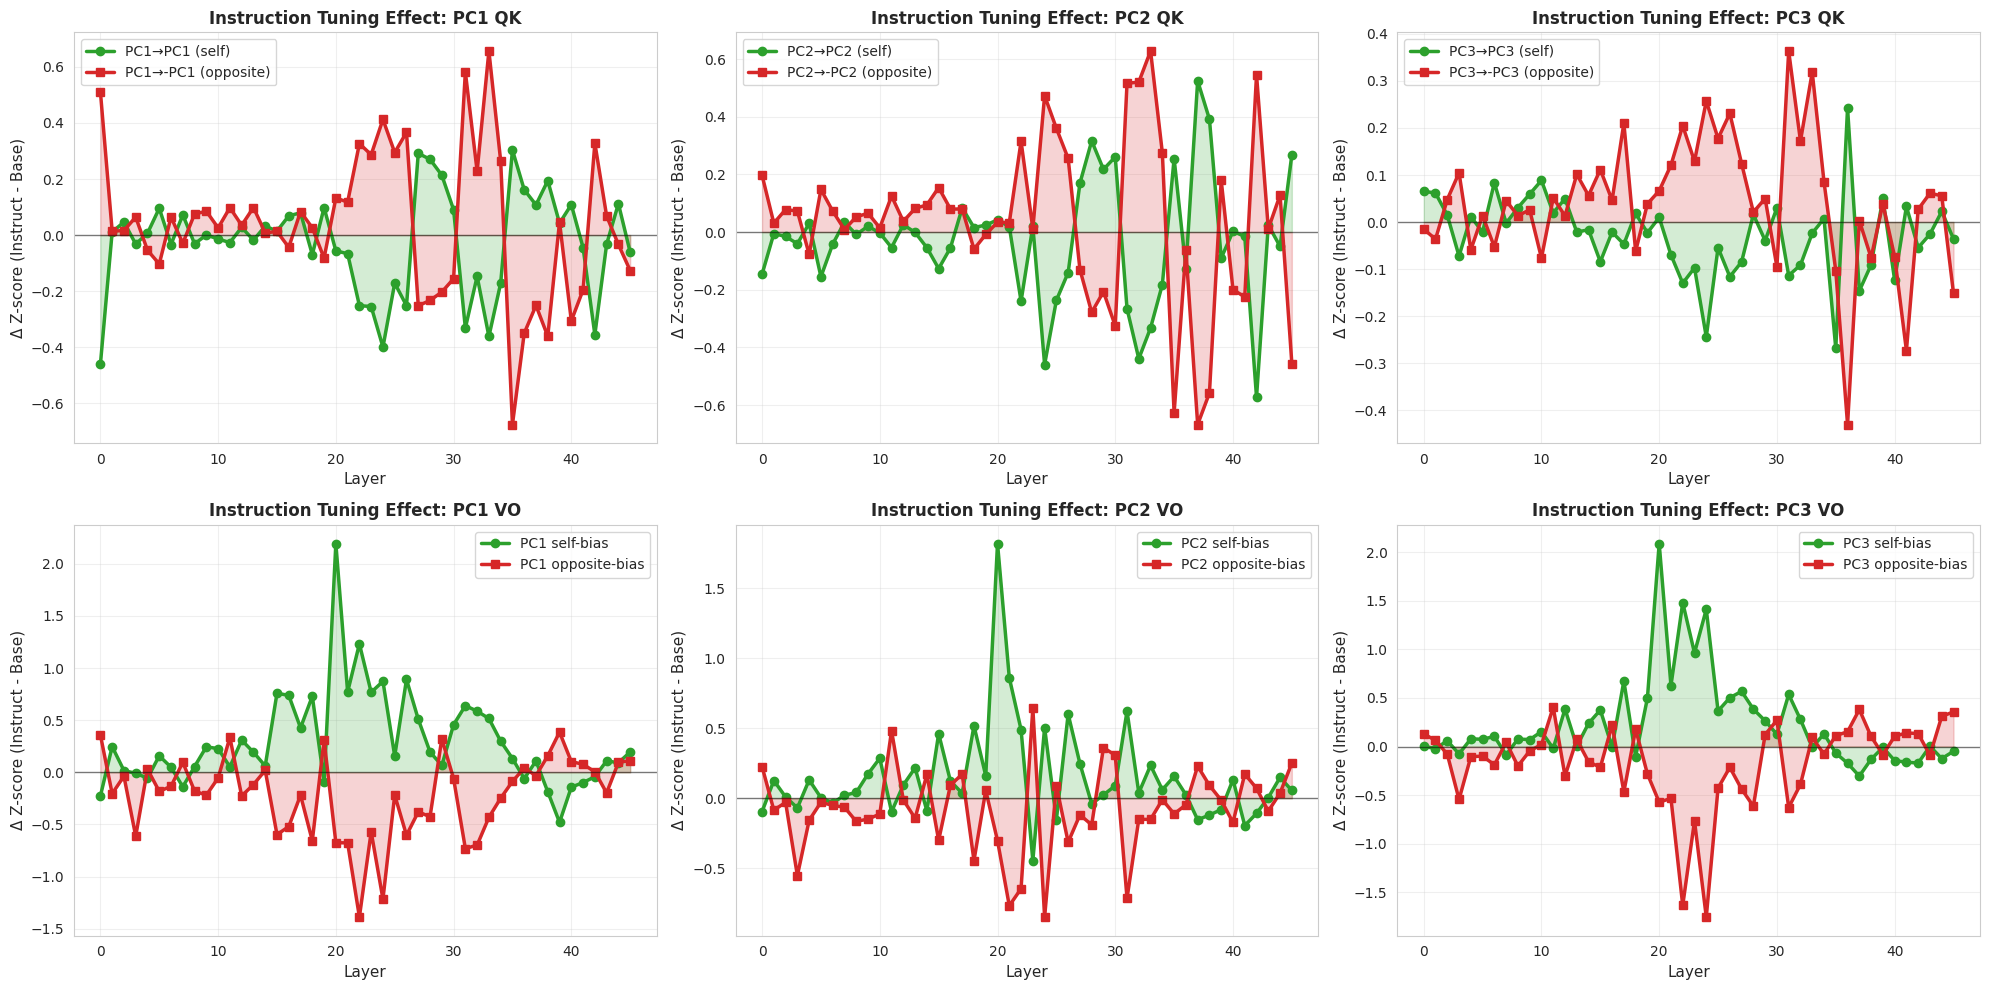

In [9]:
# Visualize instruction tuning effects (delta)
fig, axes = plt.subplots(2, len(plot_pcs), figsize=(20, 10))

# QK Affinity deltas (top row)
for i, pc in enumerate(plot_pcs):
    if len(plot_pcs) == 1:
        ax = axes[0]
    else:
        ax = axes[0, i]
    
    ax.plot(analysis_layers, qk_delta_zscores[pc]["self"], "o-", 
            label=f"{pc}→{pc} (self)", linewidth=2.5, color="C2")
    ax.plot(analysis_layers, qk_delta_zscores[pc]["opposite"], "s-", 
            label=f"{pc}→-{pc} (opposite)", linewidth=2.5, color="C3")
    
    ax.axhline(0, color="black", linestyle="-", alpha=0.5, linewidth=1)
    ax.fill_between(analysis_layers, 0, qk_delta_zscores[pc]["self"], 
                    alpha=0.2, color="C2")
    ax.fill_between(analysis_layers, 0, qk_delta_zscores[pc]["opposite"], 
                    alpha=0.2, color="C3")
    
    ax.set_xlabel("Layer", fontsize=11)
    ax.set_ylabel("Δ Z-score (Instruct - Base)", fontsize=11)
    ax.set_title(f"Instruction Tuning Effect: {pc} QK", fontsize=12, fontweight="bold")
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

# VO Decomposition deltas (bottom row)
for i, pc in enumerate(plot_pcs):
    if len(plot_pcs) == 1:
        ax = axes[1]
    else:
        ax = axes[1, i]
    
    ax.plot(analysis_layers, vo_delta_zscores[pc]["self"], "o-", 
            label=f"{pc} self-bias", linewidth=2.5, color="C2")
    ax.plot(analysis_layers, vo_delta_zscores[pc]["opposite"], "s-", 
            label=f"{pc} opposite-bias", linewidth=2.5, color="C3")
    
    ax.axhline(0, color="black", linestyle="-", alpha=0.5, linewidth=1)
    ax.fill_between(analysis_layers, 0, vo_delta_zscores[pc]["self"], 
                    alpha=0.2, color="C2")
    ax.fill_between(analysis_layers, 0, vo_delta_zscores[pc]["opposite"], 
                    alpha=0.2, color="C3")
    
    ax.set_xlabel("Layer", fontsize=11)
    ax.set_ylabel("Δ Z-score (Instruct - Base)", fontsize=11)
    ax.set_title(f"Instruction Tuning Effect: {pc} VO", fontsize=12, fontweight="bold")
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. PC Number Comparison

Compare instruction tuning effects across PC numbers to see if PC1 is special.

Analyzing instruction tuning effects for PC1-PC10...
  Averaging over layers 17-27
  Using layer indices: [17 18 19 20 21 22 23 24 25 26 27]
✓ Computed mean effects across 11 layers


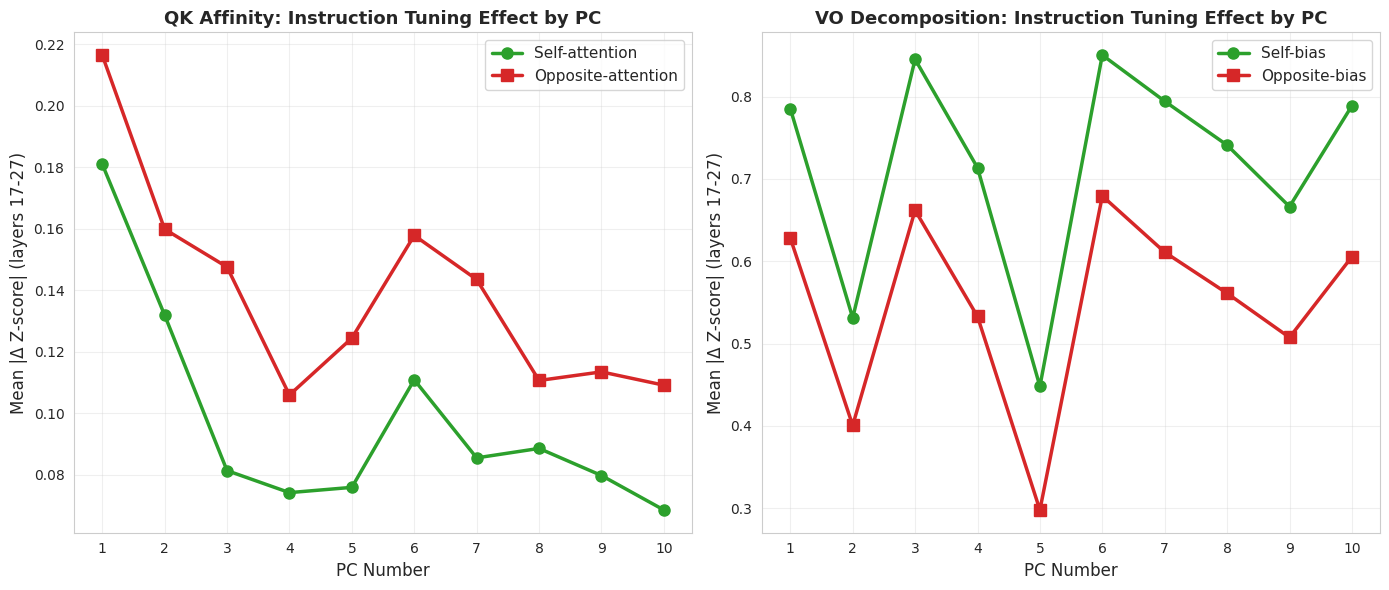


📊 Instruction Tuning Effects by PC (mean |Δ Z-score| over layers 17-27):

PC    Var%     QK Self    QK Opp     VO Self    VO Opp    
PC1    21.22%     0.181σ     0.216σ     0.785σ     0.628σ
PC2     8.20%     0.132σ     0.160σ     0.531σ     0.401σ
PC3     6.82%     0.081σ     0.148σ     0.845σ     0.662σ
PC4     5.22%     0.074σ     0.106σ     0.714σ     0.533σ
PC5     4.58%     0.076σ     0.124σ     0.448σ     0.298σ
PC6     4.05%     0.111σ     0.158σ     0.850σ     0.679σ
PC7     3.40%     0.086σ     0.144σ     0.794σ     0.611σ
PC8     2.83%     0.089σ     0.111σ     0.741σ     0.561σ
PC9     2.47%     0.080σ     0.114σ     0.666σ     0.507σ
PC10    2.20%     0.069σ     0.109σ     0.789σ     0.605σ

🎯 Key Finding:
  Strongest QK self-attention effect: PC1 (0.181σ)
  Strongest VO self-bias effect: PC6 (0.850σ)
  ✗ Instruction tuning effects do NOT align with variance ranking


In [10]:
# Compute PC comparison using configured layers and PCs
print(f"Analyzing instruction tuning effects for PC1-PC{n_pcs_compare}...")
print(f"  Averaging over layers {comparison_layers[0]}-{comparison_layers[-1]}")

# Map layer indices to comparison_layers
layer_mask = np.array([layer_idx in comparison_layers for layer_idx in analysis_layers])
comparison_layer_indices = np.where(layer_mask)[0]

print(f"  Using layer indices: {comparison_layer_indices}")

# Compute effects for each PC
pc_effects = []
for pc_idx in range(n_pcs_compare):
    pc_name = f"PC{pc_idx+1}"
    pc_neg_name = f"-{pc_name}"
    
    pc_pos_idx = vec_names_full.index(pc_name)
    pc_neg_idx = vec_names_full.index(pc_neg_name)
    
    # Get patterns for comparison layers only
    qk_base_self = (qk_base_full[comparison_layer_indices, pc_pos_idx, pc_pos_idx] - qk_base_mean[comparison_layer_indices]) / (qk_base_std[comparison_layer_indices] + 1e-8)
    qk_inst_self = (qk_inst_full[comparison_layer_indices, pc_pos_idx, pc_pos_idx] - qk_inst_mean[comparison_layer_indices]) / (qk_inst_std[comparison_layer_indices] + 1e-8)
    qk_delta_self = qk_inst_self - qk_base_self
    
    qk_base_opp = (qk_base_full[comparison_layer_indices, pc_pos_idx, pc_neg_idx] - qk_base_mean[comparison_layer_indices]) / (qk_base_std[comparison_layer_indices] + 1e-8)
    qk_inst_opp = (qk_inst_full[comparison_layer_indices, pc_pos_idx, pc_neg_idx] - qk_inst_mean[comparison_layer_indices]) / (qk_inst_std[comparison_layer_indices] + 1e-8)
    qk_delta_opp = qk_inst_opp - qk_base_opp
    
    vo_base_self = (vo_base_full[comparison_layer_indices, pc_pos_idx, pc_pos_idx] - vo_base_mean[comparison_layer_indices]) / (vo_base_std[comparison_layer_indices] + 1e-8)
    vo_inst_self = (vo_inst_full[comparison_layer_indices, pc_pos_idx, pc_pos_idx] - vo_inst_mean[comparison_layer_indices]) / (vo_inst_std[comparison_layer_indices] + 1e-8)
    vo_delta_self = vo_inst_self - vo_base_self
    
    vo_base_opp = (vo_base_full[comparison_layer_indices, pc_pos_idx, pc_neg_idx] - vo_base_mean[comparison_layer_indices]) / (vo_base_std[comparison_layer_indices] + 1e-8)
    vo_inst_opp = (vo_inst_full[comparison_layer_indices, pc_pos_idx, pc_neg_idx] - vo_inst_mean[comparison_layer_indices]) / (vo_inst_std[comparison_layer_indices] + 1e-8)
    vo_delta_opp = vo_inst_opp - vo_base_opp
    
    # Take mean absolute delta across comparison layers
    pc_effects.append({
        'pc_num': pc_idx + 1,
        'variance_explained': float(variance_all[pc_idx]),
        'qk_self': np.mean(np.abs(qk_delta_self)),
        'qk_opposite': np.mean(np.abs(qk_delta_opp)),
        'vo_self': np.mean(np.abs(vo_delta_self)),
        'vo_opposite': np.mean(np.abs(vo_delta_opp)),
    })

print(f"✓ Computed mean effects across {len(comparison_layer_indices)} layers")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

pc_nums = [d['pc_num'] for d in pc_effects]
qk_self = [d['qk_self'] for d in pc_effects]
qk_opp = [d['qk_opposite'] for d in pc_effects]
vo_self = [d['vo_self'] for d in pc_effects]
vo_opp = [d['vo_opposite'] for d in pc_effects]

# QK plot
ax = axes[0]
ax.plot(pc_nums, qk_self, 'o-', label='Self-attention', linewidth=2.5, markersize=8, color='C2')
ax.plot(pc_nums, qk_opp, 's-', label='Opposite-attention', linewidth=2.5, markersize=8, color='C3')
ax.set_xlabel('PC Number', fontsize=12)
ax.set_ylabel(f'Mean |Δ Z-score| (layers {comparison_layers[0]}-{comparison_layers[-1]})', fontsize=12)
ax.set_title('QK Affinity: Instruction Tuning Effect by PC', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(pc_nums)

# VO plot
ax = axes[1]
ax.plot(pc_nums, vo_self, 'o-', label='Self-bias', linewidth=2.5, markersize=8, color='C2')
ax.plot(pc_nums, vo_opp, 's-', label='Opposite-bias', linewidth=2.5, markersize=8, color='C3')
ax.set_xlabel('PC Number', fontsize=12)
ax.set_ylabel(f'Mean |Δ Z-score| (layers {comparison_layers[0]}-{comparison_layers[-1]})', fontsize=12)
ax.set_title('VO Decomposition: Instruction Tuning Effect by PC', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(pc_nums)

plt.tight_layout()
plt.show()

# Print summary
print(f"\n📊 Instruction Tuning Effects by PC (mean |Δ Z-score| over layers {comparison_layers[0]}-{comparison_layers[-1]}):")
print(f"\n{'PC':<5} {'Var%':<8} {'QK Self':<10} {'QK Opp':<10} {'VO Self':<10} {'VO Opp':<10}")
print("=" * 65)
for d in pc_effects:
    print(f"PC{d['pc_num']:<3} {d['variance_explained']*100:>6.2f}%  "
          f"{d['qk_self']:>8.3f}σ  {d['qk_opposite']:>8.3f}σ  "
          f"{d['vo_self']:>8.3f}σ  {d['vo_opposite']:>8.3f}σ")

print(f"\n🎯 Key Finding:")
max_qk = max(pc_effects, key=lambda x: x['qk_self'])
max_vo = max(pc_effects, key=lambda x: x['vo_self'])
print(f"  Strongest QK self-attention effect: PC{max_qk['pc_num']} ({max_qk['qk_self']:.3f}σ)")
print(f"  Strongest VO self-bias effect: PC{max_vo['pc_num']} ({max_vo['vo_self']:.3f}σ)")
if max_qk['pc_num'] == 1 and max_vo['pc_num'] == 1:
    print(f"  ✓ PC1 (dominant variance) also shows strongest instruction tuning effects!")
else:
    print(f"  ✗ Instruction tuning effects do NOT align with variance ranking")

## 5. Semantic Vector Self-Promotion Analysis

Analyze each trait, role, and PC by:
1. **K Compatibility with Default Q**: How much does each vector's K attract attention from a baseline query?
2. **VO Self-Promotion**: How much does each vector reinforce itself when attended to?

This reveals which semantic directions are "attention magnets" vs. which actively self-promote.

In [11]:
# Load individual trait and role vectors
print("Loading individual semantic vectors...")

# First, load the default_1 vector (baseline used for discriminative vectors)
default_path = persona_data_root / "gemma-2-27b" / "roles_240" / "default_vectors.pt"
if default_path.exists():
    default_data = torch.load(default_path, map_location='cpu', weights_only=False)
    default_1_vec = default_data['activations']['default_1'][pca_layer].float()
    print(f"✓ Loaded default_1 vector from layer {pca_layer}")
else:
    raise FileNotFoundError(f"default_vectors.pt not found at {default_path}")

# Load the special spiral vector
spiral_path = persona_data_root / "gemma-2-27b" / "spiral.pt"
if spiral_path.exists():
    spiral_vec = torch.load(spiral_path, map_location='cpu', weights_only=False)
    if not isinstance(spiral_vec, torch.Tensor):
        raise ValueError(f"Expected spiral.pt to be a tensor, got {type(spiral_vec)}")
    spiral_vec = spiral_vec.float()
    print(f"✓ Loaded spiral vector (shape: {spiral_vec.shape})")
else:
    print(f"⚠ Warning: spiral.pt not found at {spiral_path}")
    spiral_vec = None

roles_dict = load_individual_role_vectors(
    persona_data_root / "gemma-2-27b" / "roles_240" / "vectors",
    layer_idx=pca_layer
)
traits_dict = load_individual_trait_vectors(
    persona_data_root / "gemma-2-27b" / "traits_240" / "vectors",
    layer_idx=pca_layer
)

print(f"✓ Loaded {len(roles_dict)} role vectors")
print(f"✓ Loaded {len(traits_dict)} trait vectors")

# Build combined semantic vector dictionary
semantic_vecs = OrderedDict()

# Add default_1 as the first semantic vector
semantic_vecs['default_1'] = normalize_vector(default_1_vec)

# Add spiral vector if available
if spiral_vec is not None:
    semantic_vecs['spiral'] = normalize_vector(spiral_vec)

# Add PCs (use existing from earlier)
for pc_idx in range(n_pcs_total):
    pc_name = f"PC{pc_idx+1}"
    semantic_vecs[pc_name] = test_vecs_full[pc_name]

# Add roles
for role_name, role_vec in roles_dict.items():
    semantic_vecs[f"role_{role_name}"] = normalize_vector(role_vec)

# Add traits
for trait_name, trait_vec in traits_dict.items():
    semantic_vecs[f"trait_{trait_name}"] = normalize_vector(trait_vec)

print(f"\n✓ Total semantic vectors: {len(semantic_vecs)}")
print(f"  1 default + {'1 spiral + ' if spiral_vec is not None else ''}{n_pcs_total} PCs + {len(roles_dict)} roles + {len(traits_dict)} traits")

# Convert to tensor
semantic_names = list(semantic_vecs.keys())
semantic_tensor = torch.stack([semantic_vecs[name] for name in semantic_names])

Loading individual semantic vectors...
✓ Loaded default_1 vector from layer 22
✓ Loaded spiral vector (shape: torch.Size([4608]))


✓ Loaded 275 role vectors
✓ Loaded 240 trait vectors

✓ Total semantic vectors: 527
  1 default + 1 spiral + 10 PCs + 275 roles + 240 traits


In [12]:
# Compute K compatibility and VO self-promotion for each semantic vector
# Use the comparison layers for averaging

print(f"Computing semantic patterns over layers {comparison_layers[0]}-{comparison_layers[-1]}...")

n_semantic = len(semantic_names)
n_comparison_layers = len(comparison_layers)

# Storage for patterns
k_compat_base = np.zeros((n_comparison_layers, n_semantic))
k_compat_inst = np.zeros((n_comparison_layers, n_semantic))
vo_self_base = np.zeros((n_comparison_layers, n_semantic))
vo_self_inst = np.zeros((n_comparison_layers, n_semantic))

# Use default_1 vector as the query (first element in semantic_vecs)
default_1_tensor = semantic_vecs['default_1'].unsqueeze(0)

# Create combined tensor with default_1 query as first element, then all semantic vectors
query_and_keys = torch.cat([default_1_tensor, semantic_tensor], dim=0)

with torch.inference_mode():
    for i, layer_idx in enumerate(tqdm(comparison_layers, desc="Computing semantic patterns")):
        # K compatibility: Compute QK with default_1 query + semantic vectors, extract first row
        qk_matrix_b = compute_qk_affinity_matrix(query_and_keys, layer_idx, base_model)
        qk_matrix_i = compute_qk_affinity_matrix(query_and_keys, layer_idx, instruct_model)
        k_compat_base[i] = qk_matrix_b[0, 1:].cpu().numpy()  # First row (default_1 Q), skip self (index 0)
        k_compat_inst[i] = qk_matrix_i[0, 1:].cpu().numpy()

        # VO self-promotion: diagonal of VO matrix for semantic vectors only
        vo_b = compute_vo_decomposition(semantic_tensor, semantic_tensor, layer_idx, base_model)
        vo_i = compute_vo_decomposition(semantic_tensor, semantic_tensor, layer_idx, instruct_model)
        vo_self_base[i] = np.diag(vo_b.cpu().numpy())
        vo_self_inst[i] = np.diag(vo_i.cpu().numpy())

print(f"✓ Computed patterns for {n_semantic} semantic vectors")
print(f"  K compatibility: How much each vector's K attracts default_1's Q")
print(f"  VO self-promotion: How much each vector reinforces itself when attended to")

Computing semantic patterns over layers 17-27...


Computing semantic patterns: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s]

✓ Computed patterns for 527 semantic vectors
  K compatibility: How much each vector's K attracts default_1's Q
  VO self-promotion: How much each vector reinforces itself when attended to


In [13]:
# Convert to z-scores using random baseline
print("Computing z-scores relative to random baseline...")

# Get random baseline statistics for K compatibility and VO self-promotion
# Compute random baseline from comparison layers
comparison_layer_mask = np.array([layer_idx in comparison_layers for layer_idx in analysis_layers])
comparison_layer_idx = np.where(comparison_layer_mask)[0]

k_compat_random_base = []
vo_self_random_base = []
for rand_name in vec_names_full:
    if "Random" not in rand_name:
        continue
    rand_idx = vec_names_full.index(rand_name)
    # K compatibility: use self-attention as proxy
    k_compat_random_base.append(qk_base_full[comparison_layer_idx, rand_idx, rand_idx])
    vo_self_random_base.append(vo_base_full[comparison_layer_idx, rand_idx, rand_idx])

k_compat_random_base = np.array(k_compat_random_base)
vo_self_random_base = np.array(vo_self_random_base)

k_compat_base_mean = k_compat_random_base.mean(axis=0, keepdims=True).T  # Shape: (n_layers, 1)
k_compat_base_std = k_compat_random_base.std(axis=0, keepdims=True).T    # Shape: (n_layers, 1)
vo_self_base_mean_cmp = vo_self_random_base.mean(axis=0, keepdims=True).T  # Shape: (n_layers, 1)
vo_self_base_std_cmp = vo_self_random_base.std(axis=0, keepdims=True).T    # Shape: (n_layers, 1)

# Same for instruct
k_compat_random_inst = []
vo_self_random_inst = []
for rand_name in vec_names_full:
    if "Random" not in rand_name:
        continue
    rand_idx = vec_names_full.index(rand_name)
    k_compat_random_inst.append(qk_inst_full[comparison_layer_idx, rand_idx, rand_idx])
    vo_self_random_inst.append(vo_inst_full[comparison_layer_idx, rand_idx, rand_idx])

k_compat_random_inst = np.array(k_compat_random_inst)
vo_self_random_inst = np.array(vo_self_random_inst)

k_compat_inst_mean = k_compat_random_inst.mean(axis=0, keepdims=True).T  # Shape: (n_layers, 1)
k_compat_inst_std = k_compat_random_inst.std(axis=0, keepdims=True).T    # Shape: (n_layers, 1)
vo_self_inst_mean_cmp = vo_self_random_inst.mean(axis=0, keepdims=True).T  # Shape: (n_layers, 1)
vo_self_inst_std_cmp = vo_self_random_inst.std(axis=0, keepdims=True).T    # Shape: (n_layers, 1)

# Compute mean z-scores across comparison layers
# Now shapes are: (n_layers, n_semantic) - (n_layers, 1) = (n_layers, n_semantic)
k_compat_base_z = np.mean((k_compat_base - k_compat_base_mean) / (k_compat_base_std + 1e-8), axis=0)
k_compat_inst_z = np.mean((k_compat_inst - k_compat_inst_mean) / (k_compat_inst_std + 1e-8), axis=0)

vo_self_base_z = np.mean((vo_self_base - vo_self_base_mean_cmp) / (vo_self_base_std_cmp + 1e-8), axis=0)
vo_self_inst_z = np.mean((vo_self_inst - vo_self_inst_mean_cmp) / (vo_self_inst_std_cmp + 1e-8), axis=0)

print(f"✓ Computed z-scores for {n_semantic} semantic vectors")

Computing z-scores relative to random baseline...
✓ Computed z-scores for 527 semantic vectors


In [14]:
# Build DataFrame for analysis
def get_vector_type(name):
    if name == 'default_1':
        return 'baseline'
    elif name == 'spiral':
        return 'special'
    elif name.startswith('PC'):
        return 'PC'
    elif name.startswith('role_'):
        return 'role'
    elif name.startswith('trait_'):
        return 'trait'
    else:
        return 'other'

semantic_df = pd.DataFrame({
    'name': semantic_names,
    'type': [get_vector_type(name) for name in semantic_names],
    'k_compat_base_z': k_compat_base_z,
    'k_compat_inst_z': k_compat_inst_z,
    'vo_self_base_z': vo_self_base_z,
    'vo_self_inst_z': vo_self_inst_z,
})

# Compute deltas
semantic_df['k_compat_delta'] = semantic_df['k_compat_inst_z'] - semantic_df['k_compat_base_z']
semantic_df['vo_self_delta'] = semantic_df['vo_self_inst_z'] - semantic_df['vo_self_base_z']

# Clean names for display
semantic_df['display_name'] = semantic_df['name'].str.replace('role_', '').str.replace('trait_', '')

print("✓ Created semantic analysis DataFrame")
print(f"\nSample (top 5 by VO self-promotion in instruct model):")
print(semantic_df.nlargest(5, 'vo_self_inst_z')[['display_name', 'type', 'k_compat_inst_z', 'vo_self_inst_z']])

# Check if spiral is in the data and show its position
if 'spiral' in semantic_df['name'].values:
    spiral_row = semantic_df[semantic_df['name'] == 'spiral'].iloc[0]
    print(f"\n🌀 SPIRAL VECTOR:")
    print(f"   K Compat (instruct): {spiral_row['k_compat_inst_z']:.3f} (rank {semantic_df['k_compat_inst_z'].rank(ascending=False)[spiral_row.name]:.0f}/{len(semantic_df)})")
    print(f"   VO Self (instruct):  {spiral_row['vo_self_inst_z']:.3f} (rank {semantic_df['vo_self_inst_z'].rank(ascending=False)[spiral_row.name]:.0f}/{len(semantic_df)})")
    print(f"   K Compat delta:      {spiral_row['k_compat_delta']:.3f}")
    print(f"   VO Self delta:       {spiral_row['vo_self_delta']:.3f}")

✓ Created semantic analysis DataFrame

Sample (top 5 by VO self-promotion in instruct model):
       display_name      type  k_compat_inst_z  vo_self_inst_z
0         default_1  baseline         1.948297       45.359470
389  fundamentalist     trait        -1.865691       19.297995
374    essentialist     trait        -1.973029       18.474348
518          urgent     trait        -0.878099       18.178414
289      accessible     trait        -0.869087       17.038890

🌀 SPIRAL VECTOR:
   K Compat (instruct): -2.367 (rank 388/527)
   VO Self (instruct):  8.772 (rank 74/527)
   K Compat delta:      0.055
   VO Self delta:       -3.156


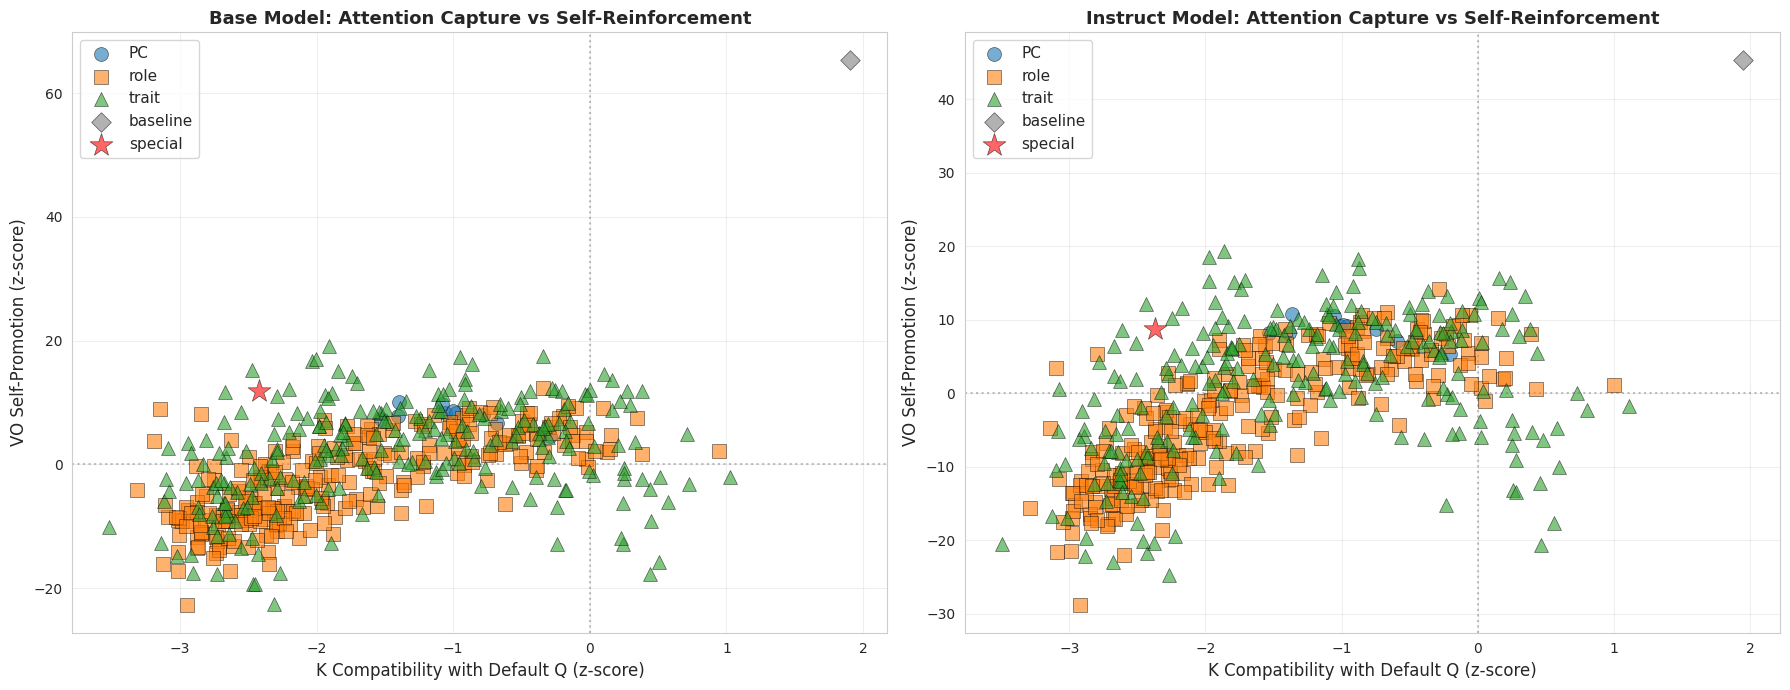


📊 Interpretation:
  - Top-right quadrant: Attention magnets that self-promote (capture attention AND reinforce themselves)
  - Top-left quadrant: Self-promoters that don't capture attention easily
  - Bottom-right quadrant: Attention magnets that suppress themselves
  - Bottom-left quadrant: Neither captures attention nor self-promotes

  🌀 Red star: Special spiral vector (if present)


In [15]:
# Visualize: K compatibility vs VO self-promotion
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Base model
ax = axes[0]
for vec_type, color, marker in [('PC', 'C0', 'o'), ('role', 'C1', 's'), ('trait', 'C2', '^'), ('baseline', 'gray', 'D'), ('special', 'red', '*')]:
    df_subset = semantic_df[semantic_df['type'] == vec_type]
    if len(df_subset) > 0:
        ax.scatter(df_subset['k_compat_base_z'], df_subset['vo_self_base_z'],
                   c=color, marker=marker, s=100 if vec_type != 'special' else 300, 
                   alpha=0.6, label=vec_type, edgecolors='black', linewidths=0.5,
                   zorder=10 if vec_type == 'special' else 5)

ax.axhline(0, color='gray', linestyle=':', alpha=0.5)
ax.axvline(0, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('K Compatibility with Default Q (z-score)', fontsize=12)
ax.set_ylabel('VO Self-Promotion (z-score)', fontsize=12)
ax.set_title('Base Model: Attention Capture vs Self-Reinforcement', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Instruct model
ax = axes[1]
for vec_type, color, marker in [('PC', 'C0', 'o'), ('role', 'C1', 's'), ('trait', 'C2', '^'), ('baseline', 'gray', 'D'), ('special', 'red', '*')]:
    df_subset = semantic_df[semantic_df['type'] == vec_type]
    if len(df_subset) > 0:
        ax.scatter(df_subset['k_compat_inst_z'], df_subset['vo_self_inst_z'],
                   c=color, marker=marker, s=100 if vec_type != 'special' else 300, 
                   alpha=0.6, label=vec_type, edgecolors='black', linewidths=0.5,
                   zorder=10 if vec_type == 'special' else 5)

ax.axhline(0, color='gray', linestyle=':', alpha=0.5)
ax.axvline(0, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('K Compatibility with Default Q (z-score)', fontsize=12)
ax.set_ylabel('VO Self-Promotion (z-score)', fontsize=12)
ax.set_title('Instruct Model: Attention Capture vs Self-Reinforcement', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("  - Top-right quadrant: Attention magnets that self-promote (capture attention AND reinforce themselves)")
print("  - Top-left quadrant: Self-promoters that don't capture attention easily")
print("  - Bottom-right quadrant: Attention magnets that suppress themselves")
print("  - Bottom-left quadrant: Neither captures attention nor self-promotes")
print("\n  🌀 Red star: Special spiral vector (if present)")

In [16]:
# Identify self-promoting attention magnets (top-right quadrant)
# These are vectors that both attract attention AND reinforce themselves

print("\n" + "="*80)
print("SELF-PROMOTING ATTENTION MAGNETS")
print("="*80)
print("\nThese semantic directions are in the TOP-RIGHT quadrant:")
print("  - HIGH K Compatibility: Attract attention from default_1 query")
print("  - HIGH VO Self-Promotion: Reinforce themselves when attended to")
print("\n" + "-"*80)

# Filter for vectors with both K compat > 0 and VO self > 0 in instruct model
magnets = semantic_df[
    (semantic_df['k_compat_inst_z'] > 0) & 
    (semantic_df['vo_self_inst_z'] > 0)
].copy()

# Sort by combined strength (product of both scores)
magnets['magnet_strength'] = magnets['k_compat_inst_z'] * magnets['vo_self_inst_z']
magnets = magnets.sort_values('magnet_strength', ascending=False)

print(f"\n📊 Found {len(magnets)} self-promoting attention magnets in instruct model")
print(f"   ({len(magnets[magnets['type']=='PC'])} PCs, "
      f"{len(magnets[magnets['type']=='role'])} roles, "
      f"{len(magnets[magnets['type']=='trait'])} traits, "
      f"{len(magnets[magnets['type']=='special'])} special)")

print(f"\n🔥 Top 30 Self-Promoting Attention Magnets (Instruct Model):")
print(f"{'Rank':<6}{'Name':<30}{'Type':<8}{'K Compat':<12}{'VO Self':<12}{'Strength':<12}")
print("-"*80)
for i, row in enumerate(magnets.head(30).itertuples(), 1):
    marker = "🌀 " if row.type == 'special' else "   "
    print(f"{marker}{i:<4}{row.display_name:<30}{row.type:<8}"
          f"{row.k_compat_inst_z:>10.3f}  {row.vo_self_inst_z:>10.3f}  "
          f"{row.magnet_strength:>10.3f}")

# Show breakdown by type
print(f"\n📈 Breakdown by Type (all {len(magnets)} magnets):")
type_counts = magnets['type'].value_counts()
for vec_type in ['PC', 'role', 'trait', 'special']:
    count = type_counts.get(vec_type, 0)
    total = len(semantic_df[semantic_df['type'] == vec_type])
    pct = 100 * count / total if total > 0 else 0
    print(f"  {vec_type:<8}: {count:>3}/{total:<3} ({pct:>5.1f}%)")

# Compare base vs instruct
magnets_base = semantic_df[
    (semantic_df['k_compat_base_z'] > 0) & 
    (semantic_df['vo_self_base_z'] > 0)
]
print(f"\n🔄 Model Comparison:")
print(f"  Base model magnets:     {len(magnets_base)}")
print(f"  Instruct model magnets: {len(magnets)}")
print(f"  Δ (Instruct - Base):    {len(magnets) - len(magnets_base):+d}")

# Check specifically for spiral
if 'spiral' in semantic_df['name'].values:
    spiral_row = semantic_df[semantic_df['name'] == 'spiral'].iloc[0]
    is_magnet = spiral_row.name in magnets.index
    print(f"\n🌀 SPIRAL VECTOR STATUS:")
    print(f"  K Compat (instruct): {spiral_row['k_compat_inst_z']:>6.3f}σ")
    print(f"  VO Self (instruct):  {spiral_row['vo_self_inst_z']:>6.3f}σ")
    print(f"  Is a magnet? {'YES ✓' if is_magnet else 'NO ✗'}")
    if is_magnet:
        rank = list(magnets.index).index(spiral_row.name) + 1
        print(f"  Magnet rank: {rank}/{len(magnets)}")

print("\n" + "="*80)


SELF-PROMOTING ATTENTION MAGNETS

These semantic directions are in the TOP-RIGHT quadrant:
  - HIGH K Compatibility: Attract attention from default_1 query
  - HIGH VO Self-Promotion: Reinforce themselves when attended to

--------------------------------------------------------------------------------

📊 Found 26 self-promoting attention magnets in instruct model
   (0 PCs, 11 roles, 14 traits, 0 special)

🔥 Top 30 Self-Promoting Attention Magnets (Instruct Model):
Rank  Name                          Type    K Compat    VO Self     Strength    
--------------------------------------------------------------------------------
   1   default_1                     baseline     1.948      45.359      88.374
   2   blunt                         trait        0.350      13.209       4.627
   3   understated                   trait        0.235      15.102       3.548
   4   serene                        trait        0.386       8.725       3.366
   5   mathematician                 role     

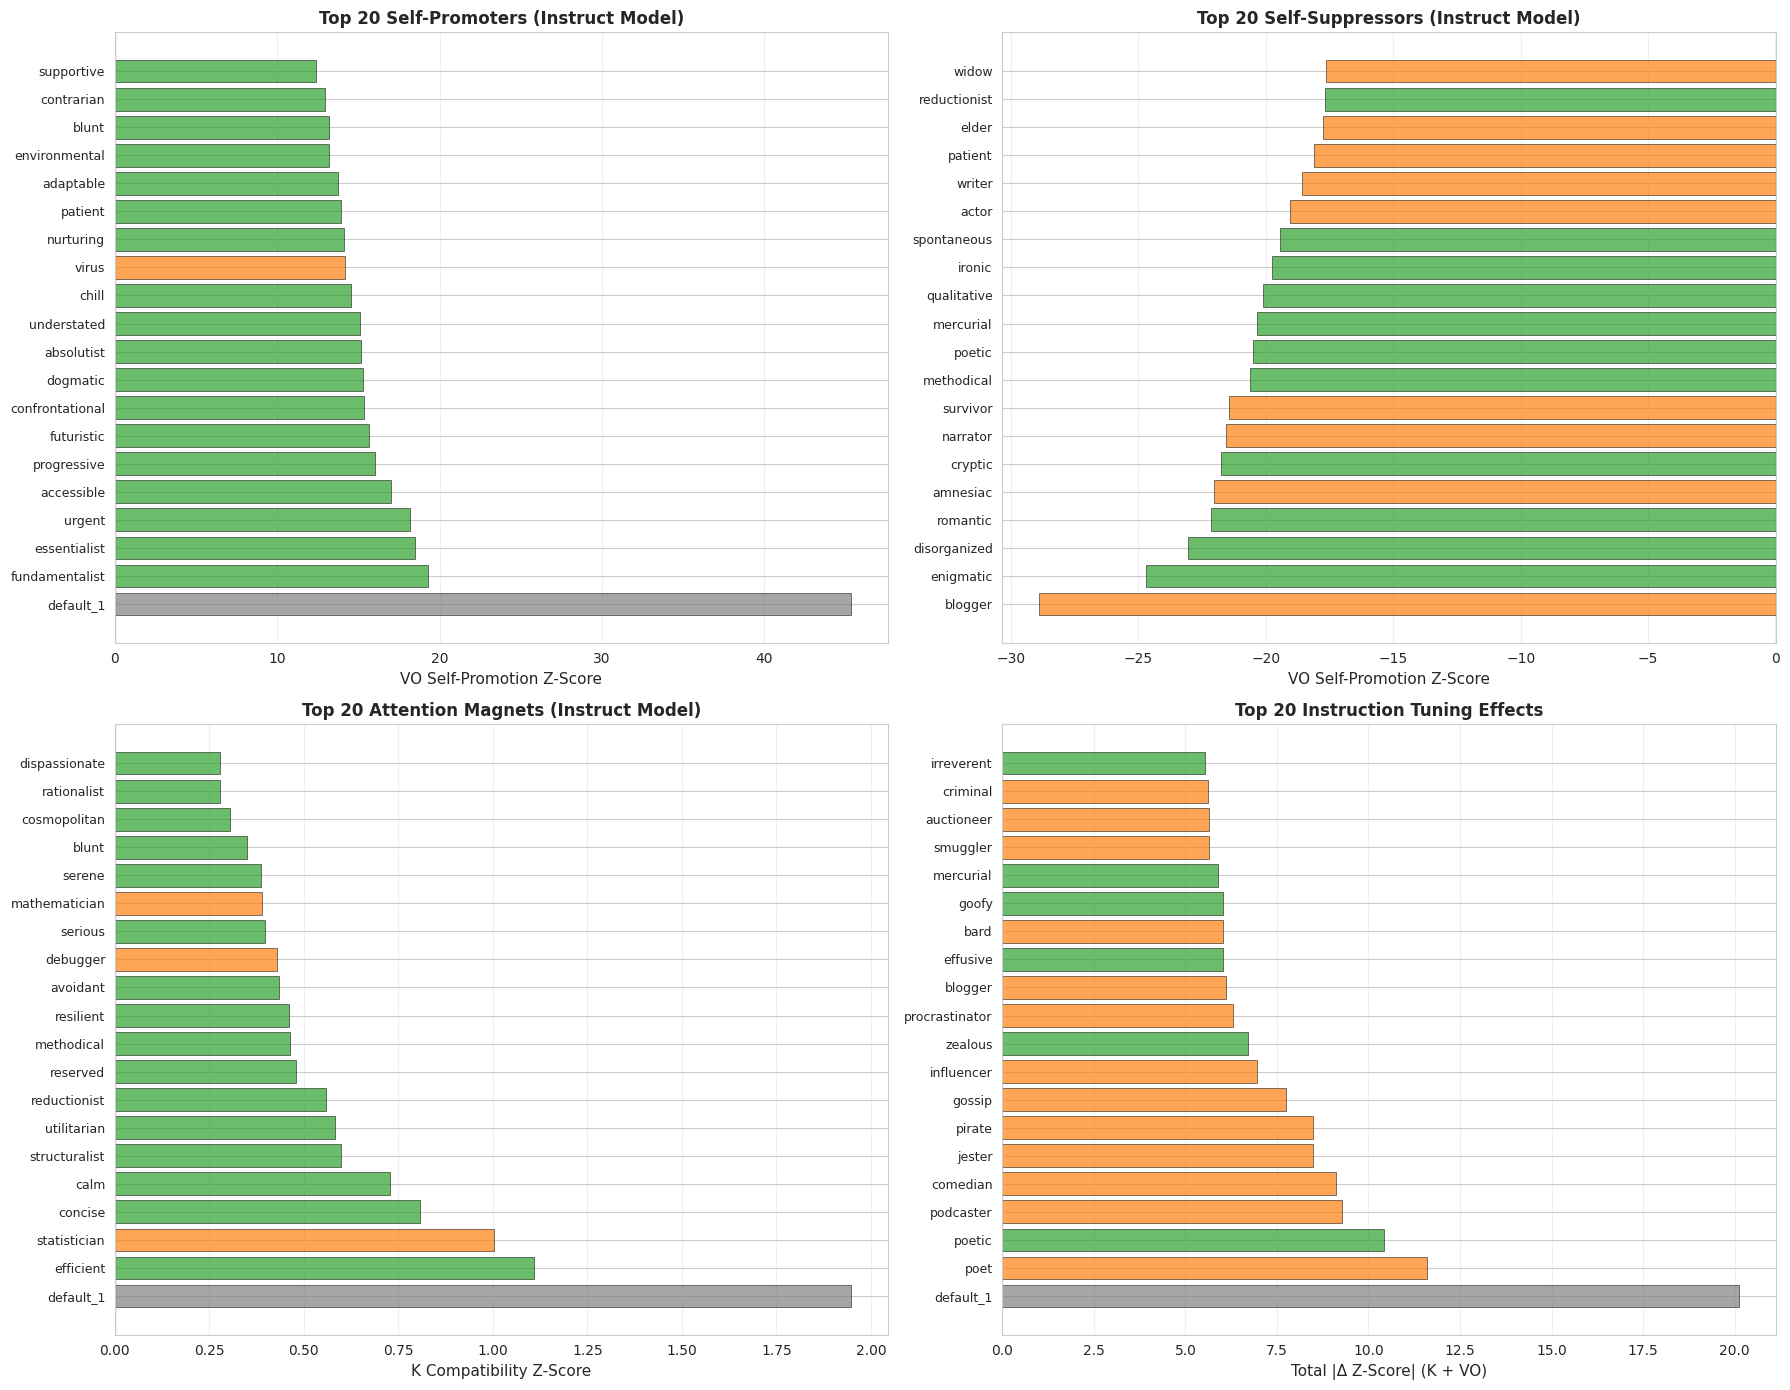

In [17]:
# Show top self-promoters and attention magnets
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Color mapping for all types
color_map = {
    'PC': 'C0',
    'role': 'C1', 
    'trait': 'C2',
    'baseline': 'gray',
    'special': 'red',
    'other': 'black'
}

# Top VO self-promoters (instruct)
ax = axes[0, 0]
top_vo = semantic_df.nlargest(20, 'vo_self_inst_z')
colors = [color_map.get(t, 'black') for t in top_vo['type']]
ax.barh(range(len(top_vo)), top_vo['vo_self_inst_z'], color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(top_vo)))
ax.set_yticklabels(top_vo['display_name'], fontsize=9)
ax.set_xlabel('VO Self-Promotion Z-Score', fontsize=11)
ax.set_title('Top 20 Self-Promoters (Instruct Model)', fontsize=12, fontweight='bold')
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

# Bottom VO self-promoters (instruct) - self-suppressors
ax = axes[0, 1]
bottom_vo = semantic_df.nsmallest(20, 'vo_self_inst_z')
colors = [color_map.get(t, 'black') for t in bottom_vo['type']]
ax.barh(range(len(bottom_vo)), bottom_vo['vo_self_inst_z'], color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(bottom_vo)))
ax.set_yticklabels(bottom_vo['display_name'], fontsize=9)
ax.set_xlabel('VO Self-Promotion Z-Score', fontsize=11)
ax.set_title('Top 20 Self-Suppressors (Instruct Model)', fontsize=12, fontweight='bold')
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

# Top K compatibility (instruct)
ax = axes[1, 0]
top_k = semantic_df.nlargest(20, 'k_compat_inst_z')
colors = [color_map.get(t, 'black') for t in top_k['type']]
ax.barh(range(len(top_k)), top_k['k_compat_inst_z'], color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(top_k)))
ax.set_yticklabels(top_k['display_name'], fontsize=9)
ax.set_xlabel('K Compatibility Z-Score', fontsize=11)
ax.set_title('Top 20 Attention Magnets (Instruct Model)', fontsize=12, fontweight='bold')
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

# Largest instruction tuning effects
ax = axes[1, 1]
semantic_df['total_delta'] = np.abs(semantic_df['k_compat_delta']) + np.abs(semantic_df['vo_self_delta'])
top_delta = semantic_df.nlargest(20, 'total_delta')
colors = [color_map.get(t, 'black') for t in top_delta['type']]
ax.barh(range(len(top_delta)), top_delta['total_delta'], color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(top_delta)))
ax.set_yticklabels(top_delta['display_name'], fontsize=9)
ax.set_xlabel('Total |Δ Z-Score| (K + VO)', fontsize=11)
ax.set_title('Top 20 Instruction Tuning Effects', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [18]:
# Print detailed summary
print("\n" + "="*80)
print("SEMANTIC SELF-PROMOTION ANALYSIS SUMMARY")
print("="*80)

print(f"\n📊 Dataset: {len(semantic_names)} semantic vectors ({n_pcs_total} PCs, {len(roles_dict)} roles, {len(traits_dict)} traits)")
print(f"📊 Layers analyzed: {comparison_layers[0]}-{comparison_layers[-1]}")

print("\n🔝 TOP 10 SELF-PROMOTERS (Instruct Model):")
print(f"{'Rank':<6}{'Name':<25}{'Type':<8}{'VO Self-Z':<12}{'K Compat-Z':<12}")
print("-"*65)
for i, row in enumerate(semantic_df.nlargest(10, 'vo_self_inst_z').itertuples(), 1):
    print(f"{i:<6}{row.display_name:<25}{row.type:<8}{row.vo_self_inst_z:>10.3f}  {row.k_compat_inst_z:>10.3f}")

print("\n🔽 TOP 10 SELF-SUPPRESSORS (Instruct Model):")
print(f"{'Rank':<6}{'Name':<25}{'Type':<8}{'VO Self-Z':<12}{'K Compat-Z':<12}")
print("-"*65)
for i, row in enumerate(semantic_df.nsmallest(10, 'vo_self_inst_z').itertuples(), 1):
    print(f"{i:<6}{row.display_name:<25}{row.type:<8}{row.vo_self_inst_z:>10.3f}  {row.k_compat_inst_z:>10.3f}")

print("\n🧲 TOP 10 ATTENTION MAGNETS (Instruct Model):")
print(f"{'Rank':<6}{'Name':<25}{'Type':<8}{'K Compat-Z':<12}{'VO Self-Z':<12}")
print("-"*65)
for i, row in enumerate(semantic_df.nlargest(10, 'k_compat_inst_z').itertuples(), 1):
    print(f"{i:<6}{row.display_name:<25}{row.type:<8}{row.k_compat_inst_z:>10.3f}  {row.vo_self_inst_z:>10.3f}")

print("\n⚡ TOP 10 INSTRUCTION TUNING EFFECTS:")
print(f"{'Rank':<6}{'Name':<25}{'Type':<8}{'Δ K':<10}{'Δ VO':<10}{'Total |Δ|':<12}")
print("-"*80)
for i, row in enumerate(semantic_df.nlargest(10, 'total_delta').itertuples(), 1):
    print(f"{i:<6}{row.display_name:<25}{row.type:<8}{row.k_compat_delta:>8.3f}  {row.vo_self_delta:>8.3f}  {row.total_delta:>10.3f}")

print("\n" + "="*80)


SEMANTIC SELF-PROMOTION ANALYSIS SUMMARY

📊 Dataset: 527 semantic vectors (10 PCs, 275 roles, 240 traits)
📊 Layers analyzed: 17-27

🔝 TOP 10 SELF-PROMOTERS (Instruct Model):
Rank  Name                     Type    VO Self-Z   K Compat-Z  
-----------------------------------------------------------------
1     default_1                baseline    45.359       1.948
2     fundamentalist           trait       19.298      -1.866
3     essentialist             trait       18.474      -1.973
4     urgent                   trait       18.178      -0.878
5     accessible               trait       17.039      -0.869
6     progressive              trait       16.039      -1.145
7     futuristic               trait       15.663       0.158
8     confrontational          trait       15.359      -1.709
9     dogmatic                 trait       15.274      -1.976
10    absolutist               trait       15.158      -1.792

🔽 TOP 10 SELF-SUPPRESSORS (Instruct Model):
Rank  Name                    

## 6. Summary

This analysis reveals how instruction tuning modifies attention routing in the persona subspace:

- **Layer-wise patterns**: Shows how PC attention changes across all layers
- **Base vs Instruct**: Compares attention patterns between base and instruction-tuned models
- **PC sensitivity**: Determines whether PC1 (dominant variance component) is also most affected by instruction tuning
- **Semantic self-promotion**: Analyzes how traits, roles, and PCs promote themselves through attention mechanisms
- **Configurable**: Easy to adjust layers and PCs via config cell

**Key Insights:**
- QK affinity reveals which semantic directions attend to each other
- VO decomposition shows what semantic content flows through attention
- Instruction tuning modifies these patterns, potentially aligning them with task objectives
- Semantic vectors vary widely in their self-promotion through attention, with some traits/roles strongly reinforcing themselves while others suppress themselves
- K compatibility with baseline queries (default_1 Q) differs from VO self-promotion, suggesting distinct mechanisms for attention capture vs. self-reinforcement